# HarvestStat Data Profiling - Zimbabwe

In [1]:
import os, sys, glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32736' # Zimbabwe
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/ZW_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
#PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# Note that we need the login for the ZW alternate time series
auth = tuple(json.loads(open('token.json', "r").read()))

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Zimbabwe',
    'product': ['R011','R012','R013','R014','R015','R017','R018'],
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint,params=parameters, auth=auth, proxies={})# 
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())

# ----------------------------------------------- #
print(df.shape)

(102824, 66)


In [3]:
# Save data
df_raw_out = '../data/crop_raw_data/adm_crop_data_raw_ZW.csv'
df.to_csv(df_raw_out); print(f'{df_raw_out} is saved.')

../data/crop_raw_data/adm_crop_data_raw_ZW.csv is saved.


In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
#  None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
#Drop the hundreds of blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)

# ----------------------------------------------- #
# ----------------------------------------------- #
df_r = df[df['admin_2'].isna()]
df_r['admin_0']='Zimbabwe'
df_admin2 = df.dropna(subset=['admin_2'])

df_r['fnid'] = df_r['fnid'].str[:10]
df_r['fnid'] = df_r['fnid'].str.replace('R3', 'A1')


shape_used=pd.concat([ZW_Admin1_1981,ZW_Admin1_1993],axis=0)
fnidMap = shape_used.set_index(['FNID'])['ADMIN1'].to_dict()
df_r['admin_1'] = df_r['fnid'].map(fnidMap)
df_r['name']=df_r['admin_1']

aggProd = df_r.loc[df_r.indicator == 'Quantity Produced', ['country','country_code','fnid','admin_0','admin_1','name','season_year',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value']].groupby(
                            ['country','country_code','fnid','admin_0','admin_1','name','season_year',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator']).sum()
aggArea = df_r.loc[df_r.indicator == 'Area Harvested', ['country','country_code','fnid','admin_0','admin_1','name','season_year',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value']].groupby(
                            ['country','country_code','fnid','admin_0','admin_1','name','season_year',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator']).sum()

aggProd.reset_index(inplace=True)
aggArea.reset_index(inplace=True)
tempProd = aggProd.copy()
aggYld = tempProd
aggYld['value'] = tempProd['value'] / aggArea['value']

aggProd['indicator'] = 'Quantity Produced'
aggArea['indicator'] = 'Area Harvested'
aggYld['indicator'] = 'Yield'

df = pd.concat([aggProd, aggArea, aggYld])
df['year']=df['harvest_year']
df['admin_2']=''
df['admin_3']=''
df['admin_4']=''
table_dict = FDW_PD_AvalTable(df, shape_all)
# FEWS NET Shapefile comparison ----------------- #

PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 60,249
20,585/20,585 "Area Planted" points are retained.
20,110/20,110 "Quantity Produced" points are retained.
19,554/19,554 "Yield" points are retained.
Current data points: 60,249

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1981 - 2023
18 grain types are found: Bambara groundnut, Beans (Rosecoco), Cassava, Cowpea (unspecified), Groundnuts (In Shell), Maize Grain (White), Millet, Millet (Bulrush), Millet (Finger), NUA 45, Rape, Rice (Paddy), Sesame Seed, Sorghum, Sorghum (Brown), Soybean (unspecified), Sunflower Seed, Sweet Potatoes
1 seasons are found: Main (04-01)
8 crop production system are found: Communal (PS), All (PS), SSCF (PS), A2 (PS), CA (PS), LSCF (PS), OR (PS), A1 (PS)
Data sources include:
[1] Ministry of Agriculture, AGRITEX, Zimbabwe --- Agritex field survey reports, Zimbabwe
[2] Ministry of Agriculture, AGRITEX, Zimbabwe --- A

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = ZW_Admin1_1993.copy().to_crs('epsg:32736')
# ----------------------------------------------- #

- Zimbabwe crop seasonal calendar

![FEWS NET](../figures/crop_calendar/seasonal-calendar-zimbabwe.png)
<img src="../figures/crop_calendar/Zimbabwe_-_Crop_calendar.jpg"  width="60%">

- FDW data consists of `ZW2011A2`.

| Year  | Admin-1  | # units  | Admin-2  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   |
| 1981	 | ZW1981A1 | 8	| ZW1981A2	| 58	|
| 2007	 | ZW2007A1 | 10	| ZW2007A2	| 84	|
| 2008	 | ZW2008A1 | 10	| ZW2008A2	| 84	|
| 2009	 | ZW2009A1 | 10	| ZW2009A2	| 85	|
| 2011	 | ZW2011A1 | 10	| **`ZW2011A2`**	| 89	|

- Comparison between admin boundaries.

<img src="../figures/ZW_admin_shapes.png"  width="60%">

In [6]:
# # ----------------------------------------------- #
# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

df_commLands = df.copy()


In [7]:
#Restart the whole process again to pull the native admin 1 level data

# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32736' # Zimbabwe
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/ZW_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Zimbabwe',
   'product': ['R011','R012','R013','R014','R015','R017','R018'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionfacts/'
response = requests.get(host + endpoint, params=parameters, proxies={}, auth = auth)
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1981	 | ZW1981A1 | 8	| ZW1981A2	| 58	| nan	| 0	|
| 1993	 | ZW1993A1 | 8	| ZW1993A2	| 59	| nan	| 0	|
| 2007	 | ZW2007A1 | 10	| ZW2007A2	| 84	| nan	| 0	|
| 2008	 | ZW2008A1 | 10	| ZW2008A2	| 84	| nan	| 0	|
| 2009	 | ZW2009A1 | 10	| ZW2009A2	| 85	| nan	| 0	|
| 2011	 | ZW2011A1 | 10	| ZW2011A2	| 89	| nan	| 0	|
| 2018	 | ZW2018A1 | 10	| ZW2018A2	| 89	| nan	| 0	|
----------------------------------------------- #


In [8]:
# Manual Pre-processing before Sweeping --------- #

# Select the alternate dataset, which is the admin 1 dataset for Zimbabwe
df = df[df.source_document.str[:3]=='Alt']

#drop overlapping years
df = df[df.period_date.str[:4].astype(int)>2000]

# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ZW_Admin1_1981,ZW_Admin1_1993,ZW_Admin1_2007, ZW_Admin1_2009, ZW_Admin1_2011, ZW_Admin1_2018], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 5,712
Removed 1,745 "Missing Value" points
0/1,428 "Area Harvested" points are retained.
1,370/1,428 "Area Planted" points are retained.
1,298/1,428 "Quantity Produced" points are retained.
1,299/1,428 "Yield" points are retained.
Current data points: 3,967

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 2001 - 2023
16 grain types are found: Bambara groundnut, Beans (Rosecoco), Cassava, Cowpea (unspecified), Groundnuts (In Shell), Maize Grain (White), Millet (Bulrush), Millet (Finger), NUA 45, Rape, Rice (Paddy), Sesame Seed, Sorghum, Soybean (unspecified), Sunflower Seed, Sweet Potatoes
1 seasons are found: Main (04-01)
7 crop production system are found: OR (PS), A1 (PS), CA (PS), All (PS), A2 (PS), SSCF (PS), LSCF (PS)
Data sources include:
[1] MoA, Zimbabwe --- Alt_Ad1_Ministry of Agriculture Crop Assessment Report 2nd round, Zimbabwe
[2] MoA, Z

In [9]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = ZW_Admin1_2018.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

#Merge the communal land data with the admin 1 data
df=pd.concat([df,df_commLands])

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [10]:
# Link admin boundaries ------------------------- #
link_1981, over_1981 = FDW_PD_CreateAdminLink(ZW_Admin1_1981, ZW_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1993, over_1993 = FDW_PD_CreateAdminLink(ZW_Admin1_1993, ZW_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2007, over_2007 = FDW_PD_CreateAdminLink(ZW_Admin1_2007, ZW_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2009, over_2009 = FDW_PD_CreateAdminLink(ZW_Admin1_2009, ZW_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2011, over_2011 = FDW_PD_CreateAdminLink(ZW_Admin1_2011, ZW_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)

link_ratio_1981 = FDW_PD_RatioAdminLink(link_1981, prod, over_1981, mdx_pss)
link_ratio_1993 = FDW_PD_RatioAdminLink(link_1993, prod, over_1993, mdx_pss)
link_ratio_2007 = FDW_PD_RatioAdminLink(link_2007, prod, over_2007, mdx_pss)
link_ratio_2009 = FDW_PD_RatioAdminLink(link_2009, prod, over_2009, mdx_pss)
link_ratio_2011 = FDW_PD_RatioAdminLink(link_2011, prod, over_2011, mdx_pss)

# Merge link_ratio
assert link_ratio_1981.keys() == link_ratio_2011.keys()
assert link_ratio_1993.keys() == link_ratio_2011.keys()
assert link_ratio_2007.keys() == link_ratio_2011.keys()
assert link_ratio_2009.keys() == link_ratio_2011.keys()


link_merged = [link_ratio_1981,link_ratio_1993,link_ratio_2007,link_ratio_2009,link_ratio_2011]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack= stack[names]
df = stack
#df['indicator']=df['indicator'].replace({'area':'Area Harvested','production':'Quantity Produced','yield':'Yield'})

CBR is considered for 'ZW1981A103' as no record found in: ['ZW2018A119']
CBR is considered for 'ZW1981A106' as no record found in: ['ZW2018A110']
CBR is considered for 'ZW1993A103' as no record found in: ['ZW2018A119']
CBR is considered for 'ZW1993A106' as no record found in: ['ZW2018A110']
CBR is considered for 'ZW2011A110' as no record found in: ['ZW2018A110']
CBR is considered for 'ZW2011A119' as no record found in: ['ZW2018A119']


In [11]:

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0


# Save data
fn_out = '../data/crop/adm_crop_production_ZW.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_ZW_ratio.npz', link_ratio)

All [country, season_name] are in the external season calendar.
../data/crop/adm_crop_production_ZW.csv is saved.
../data/crop/adm_crop_production_ZW_ratio.npz is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


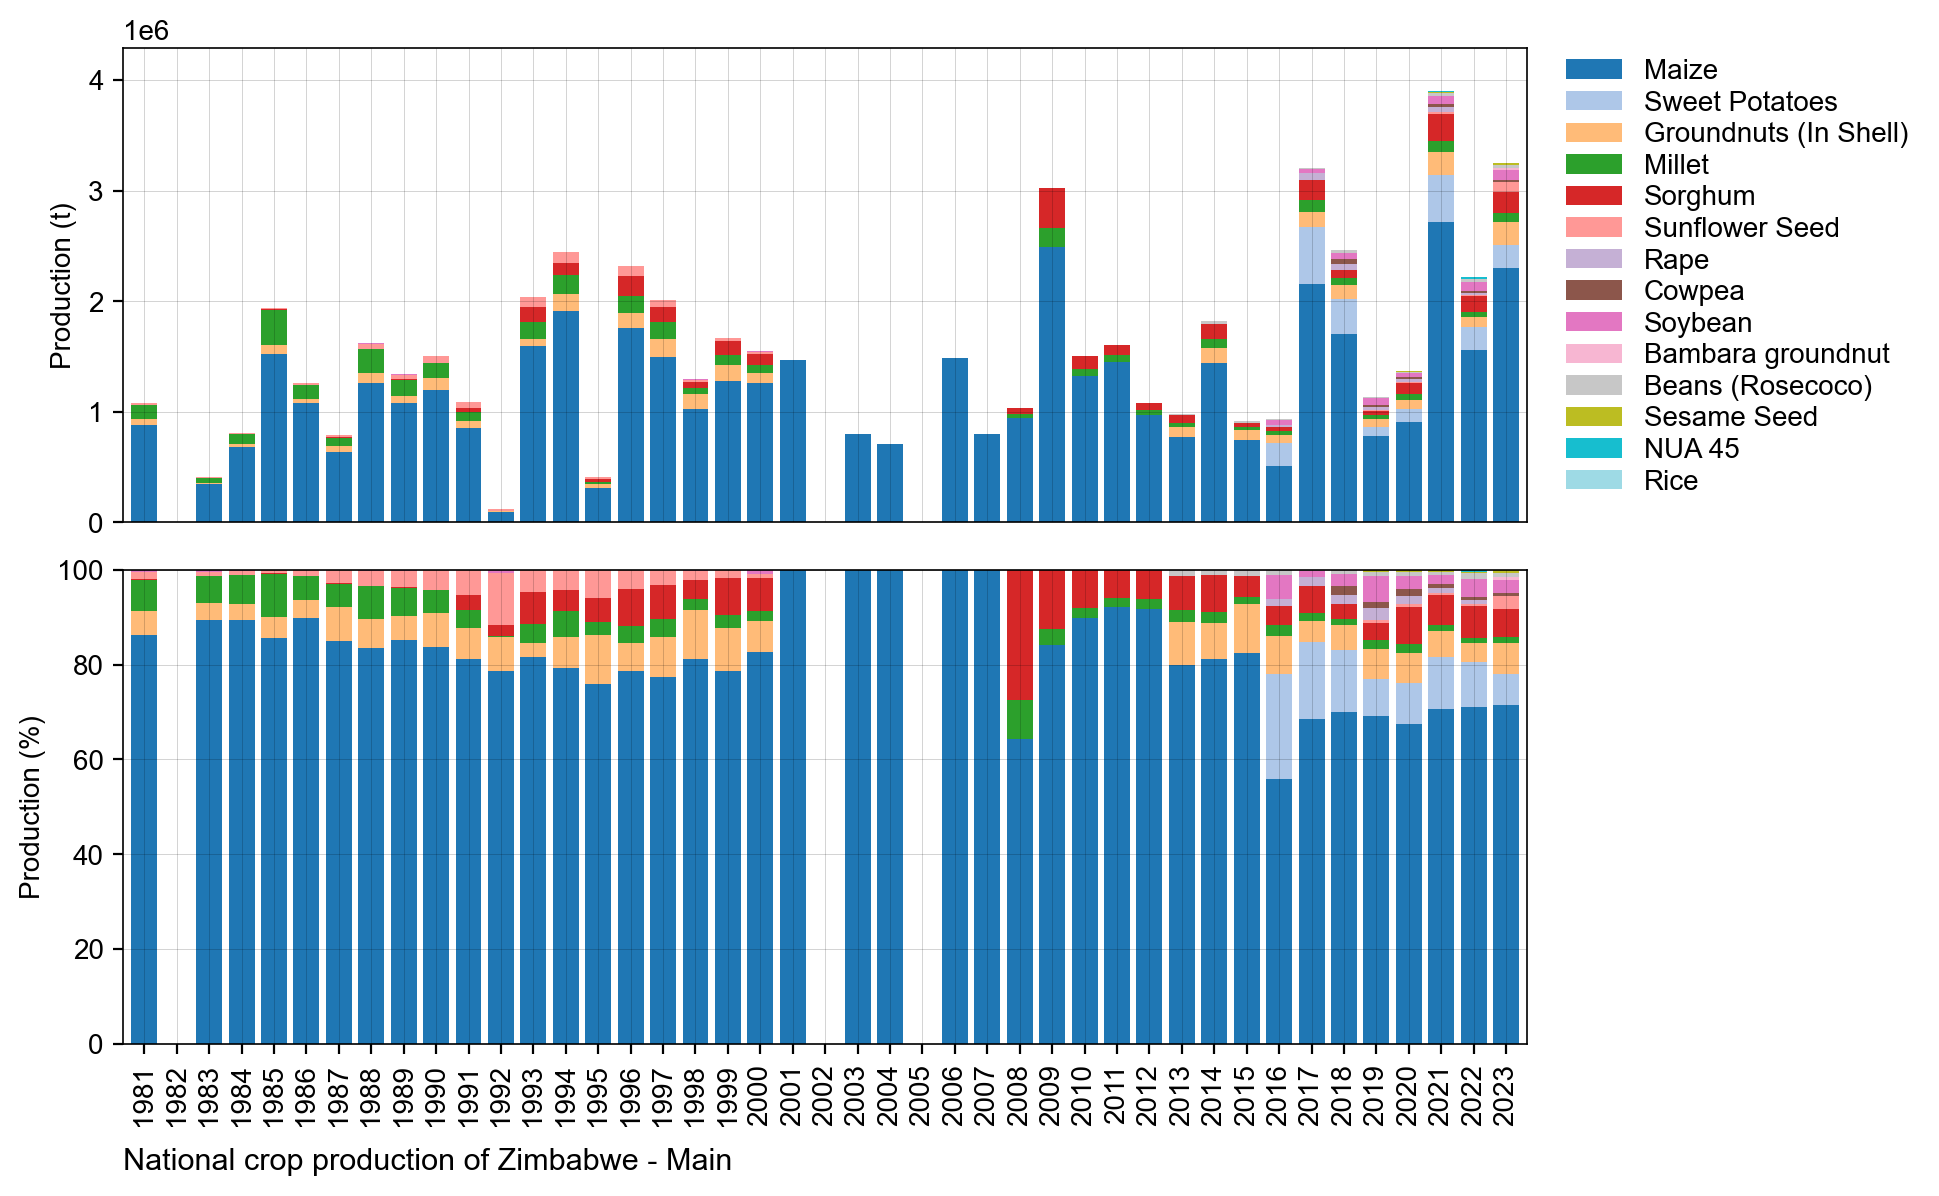

../figures/ZW_bar_natgrainprod_Main.png is saved.


In [12]:
# Bar chart of national crop production
country_iso, country_name = 'ZW', 'Zimbabwe'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = "../figures/%s_bar_natgrainprod_%s.png" % (country_iso, season_name)
    if season_name == 'Long/Dry': 
        fn_save = "../figures/%s_bar_natgrainprod_%s.png" % (country_iso, "Long_and_Dry")
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(bbox_to_anchor=(1.01, 1.03), loc='upper left', frameon=False, labelspacing=0.2)


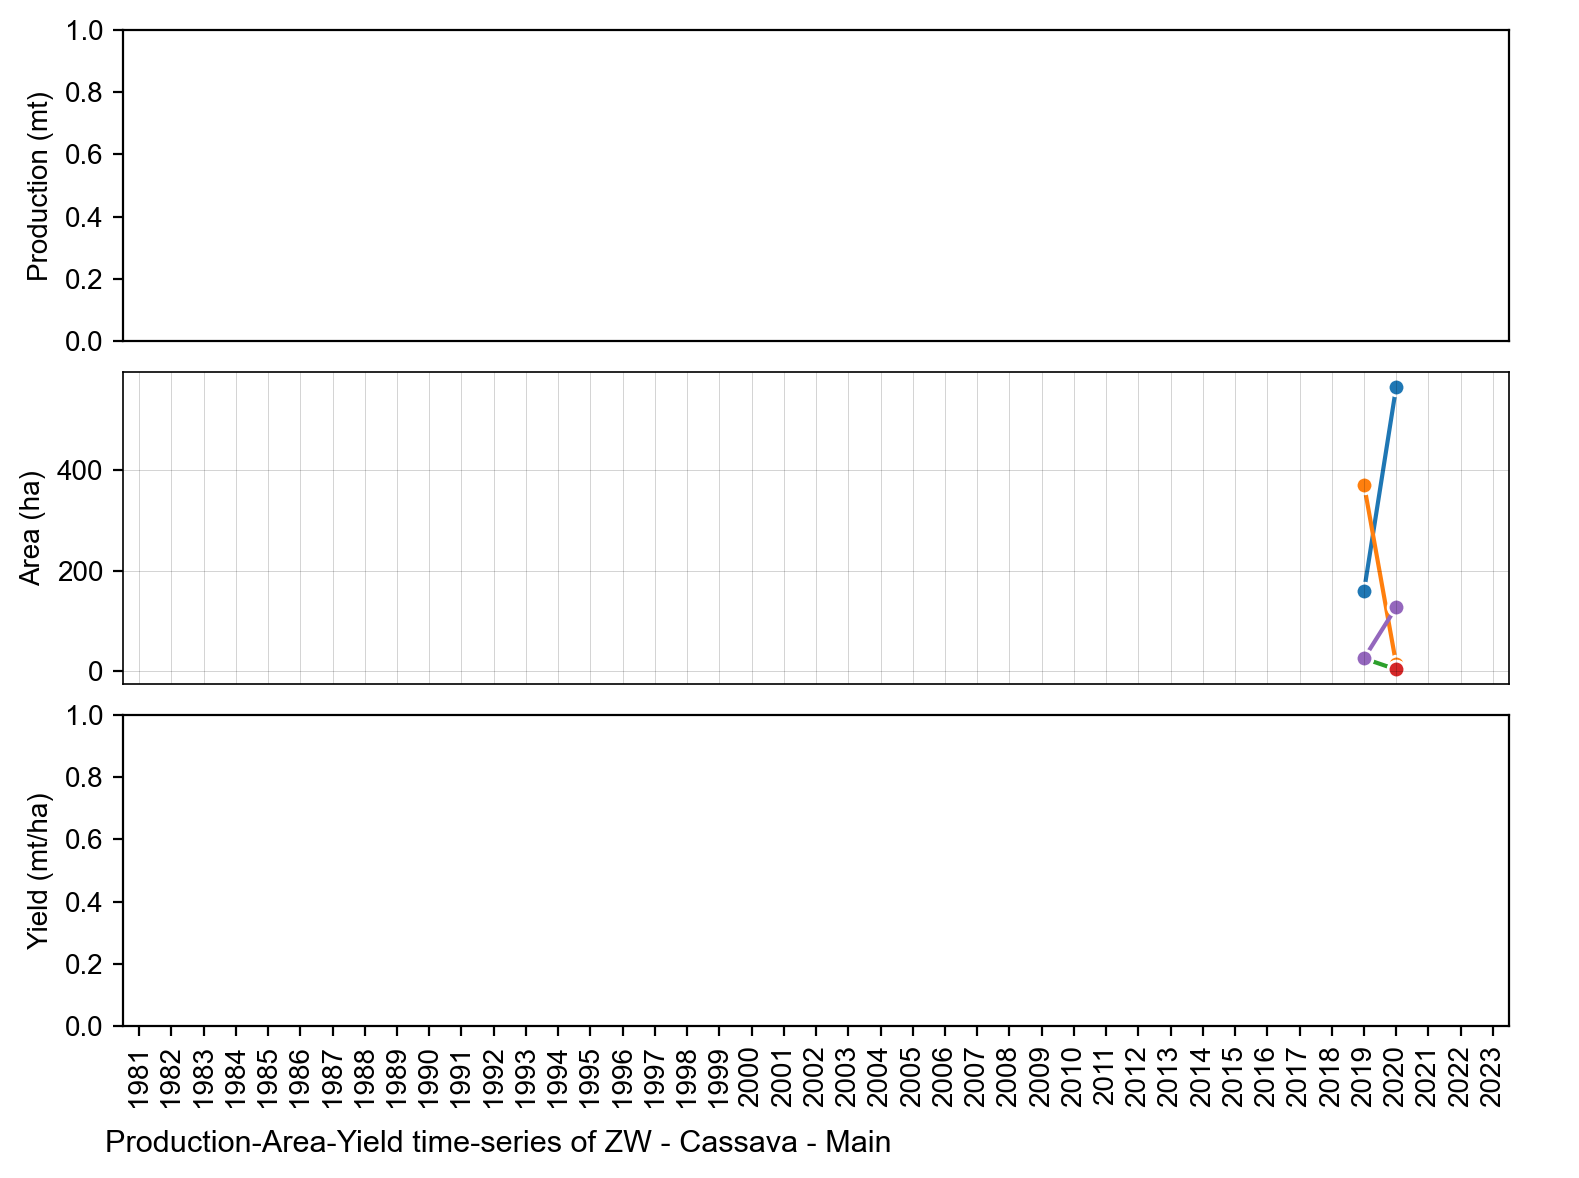

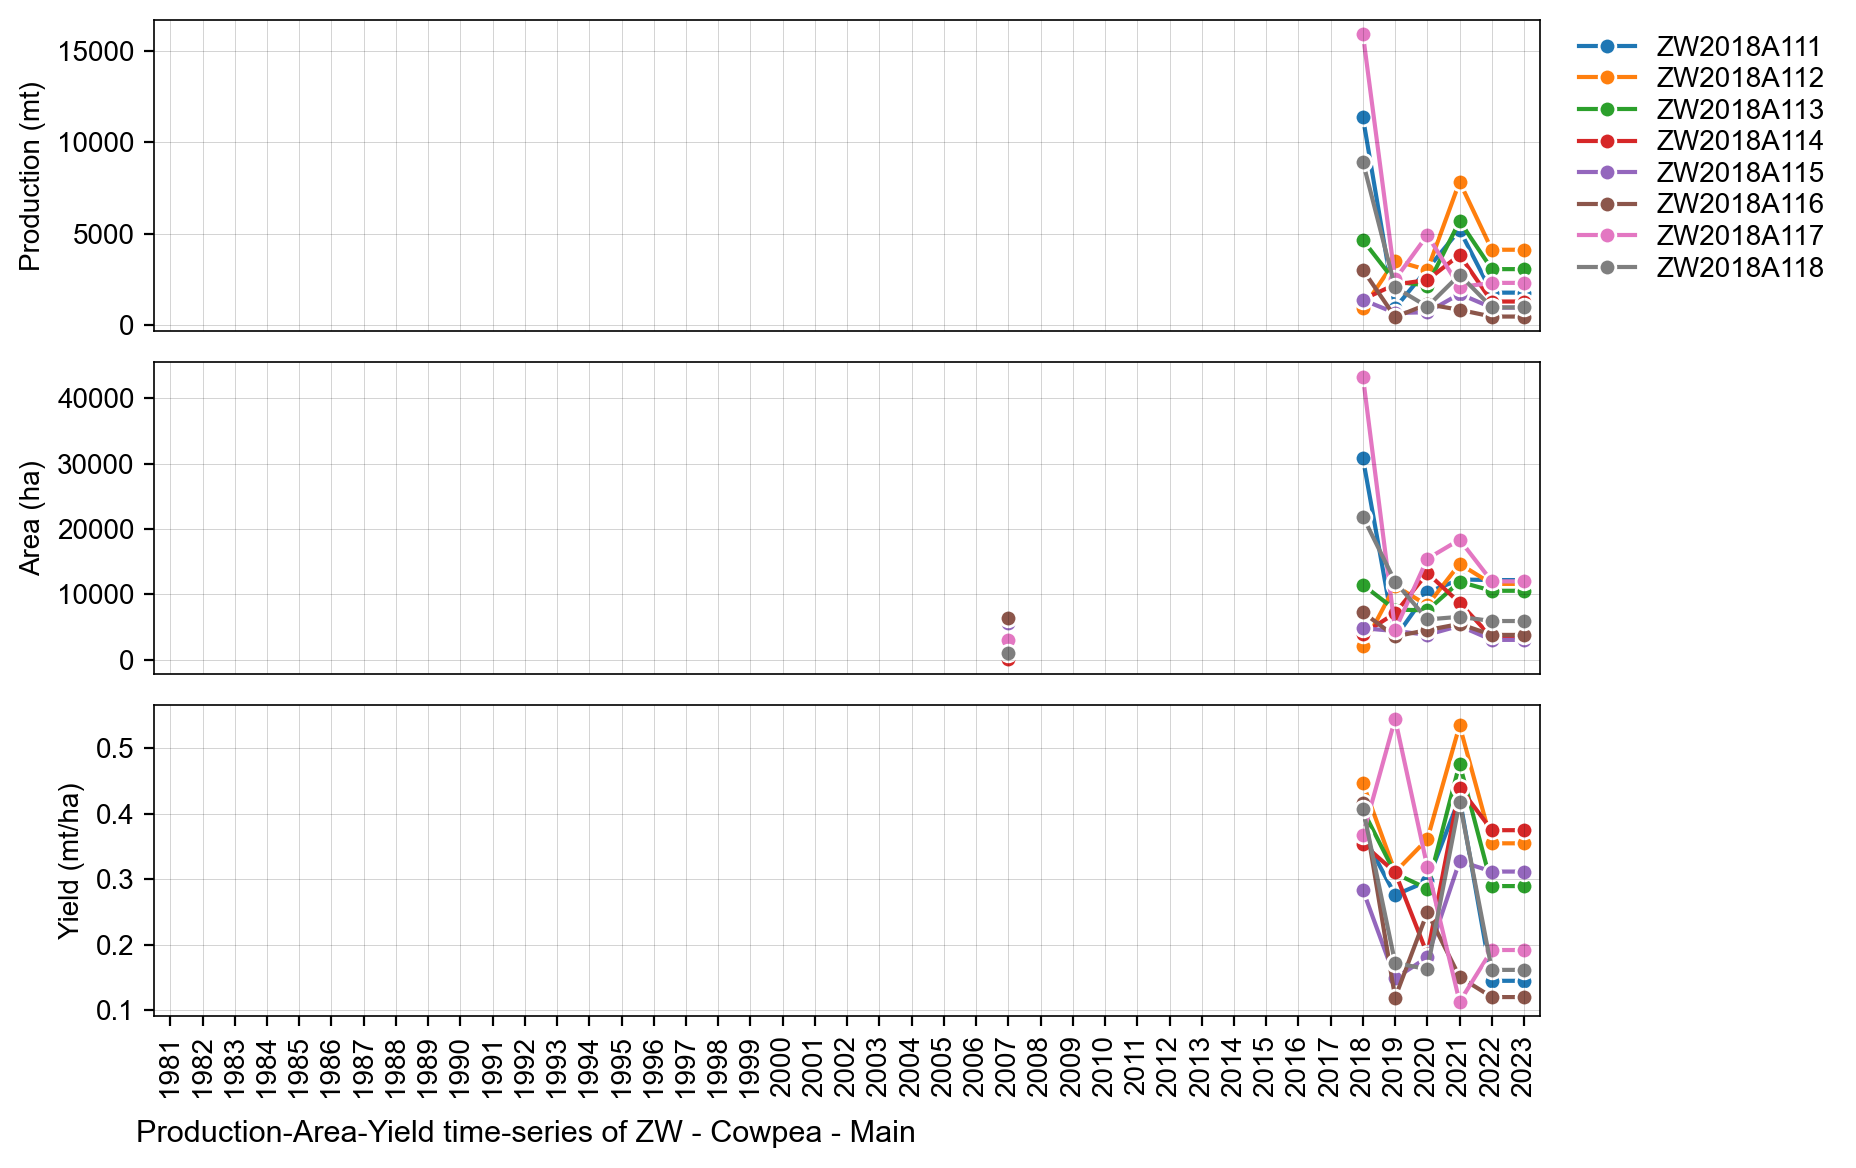

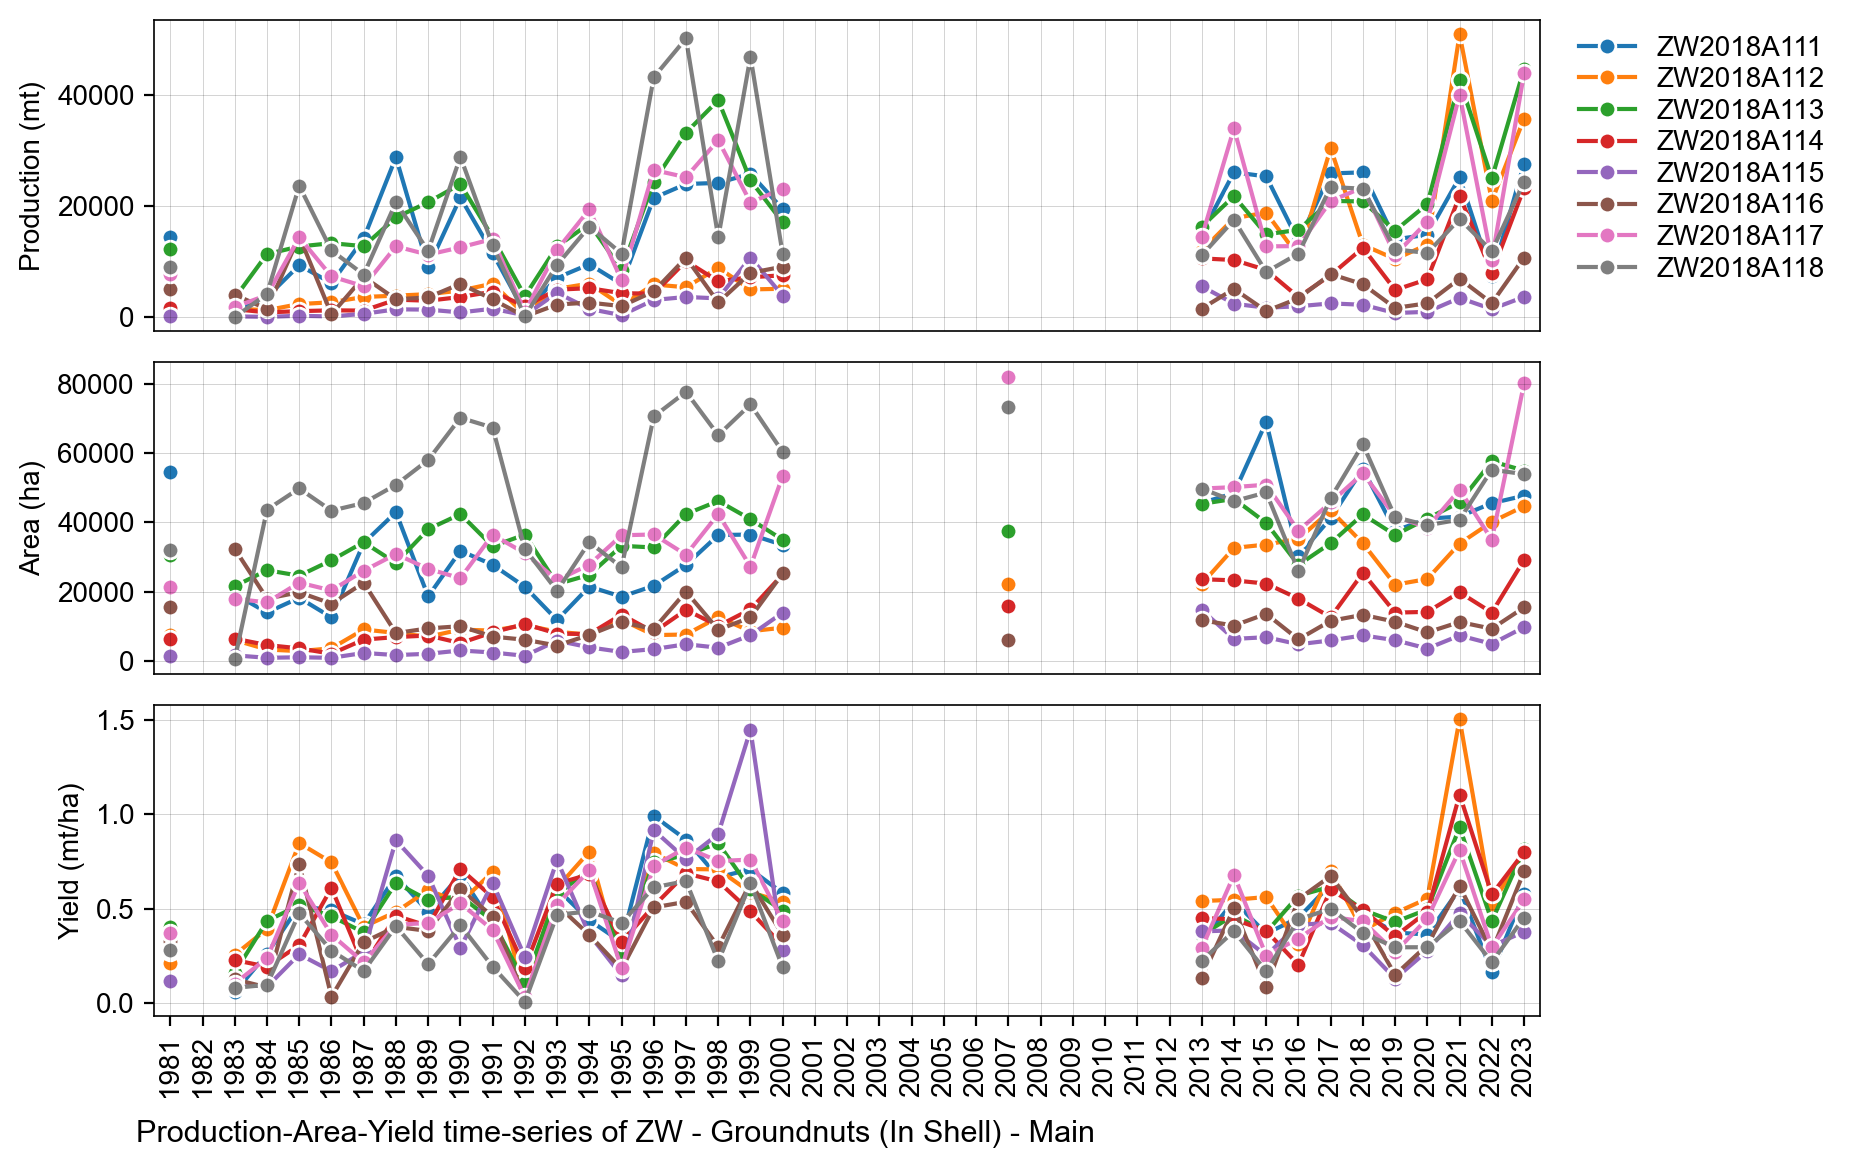

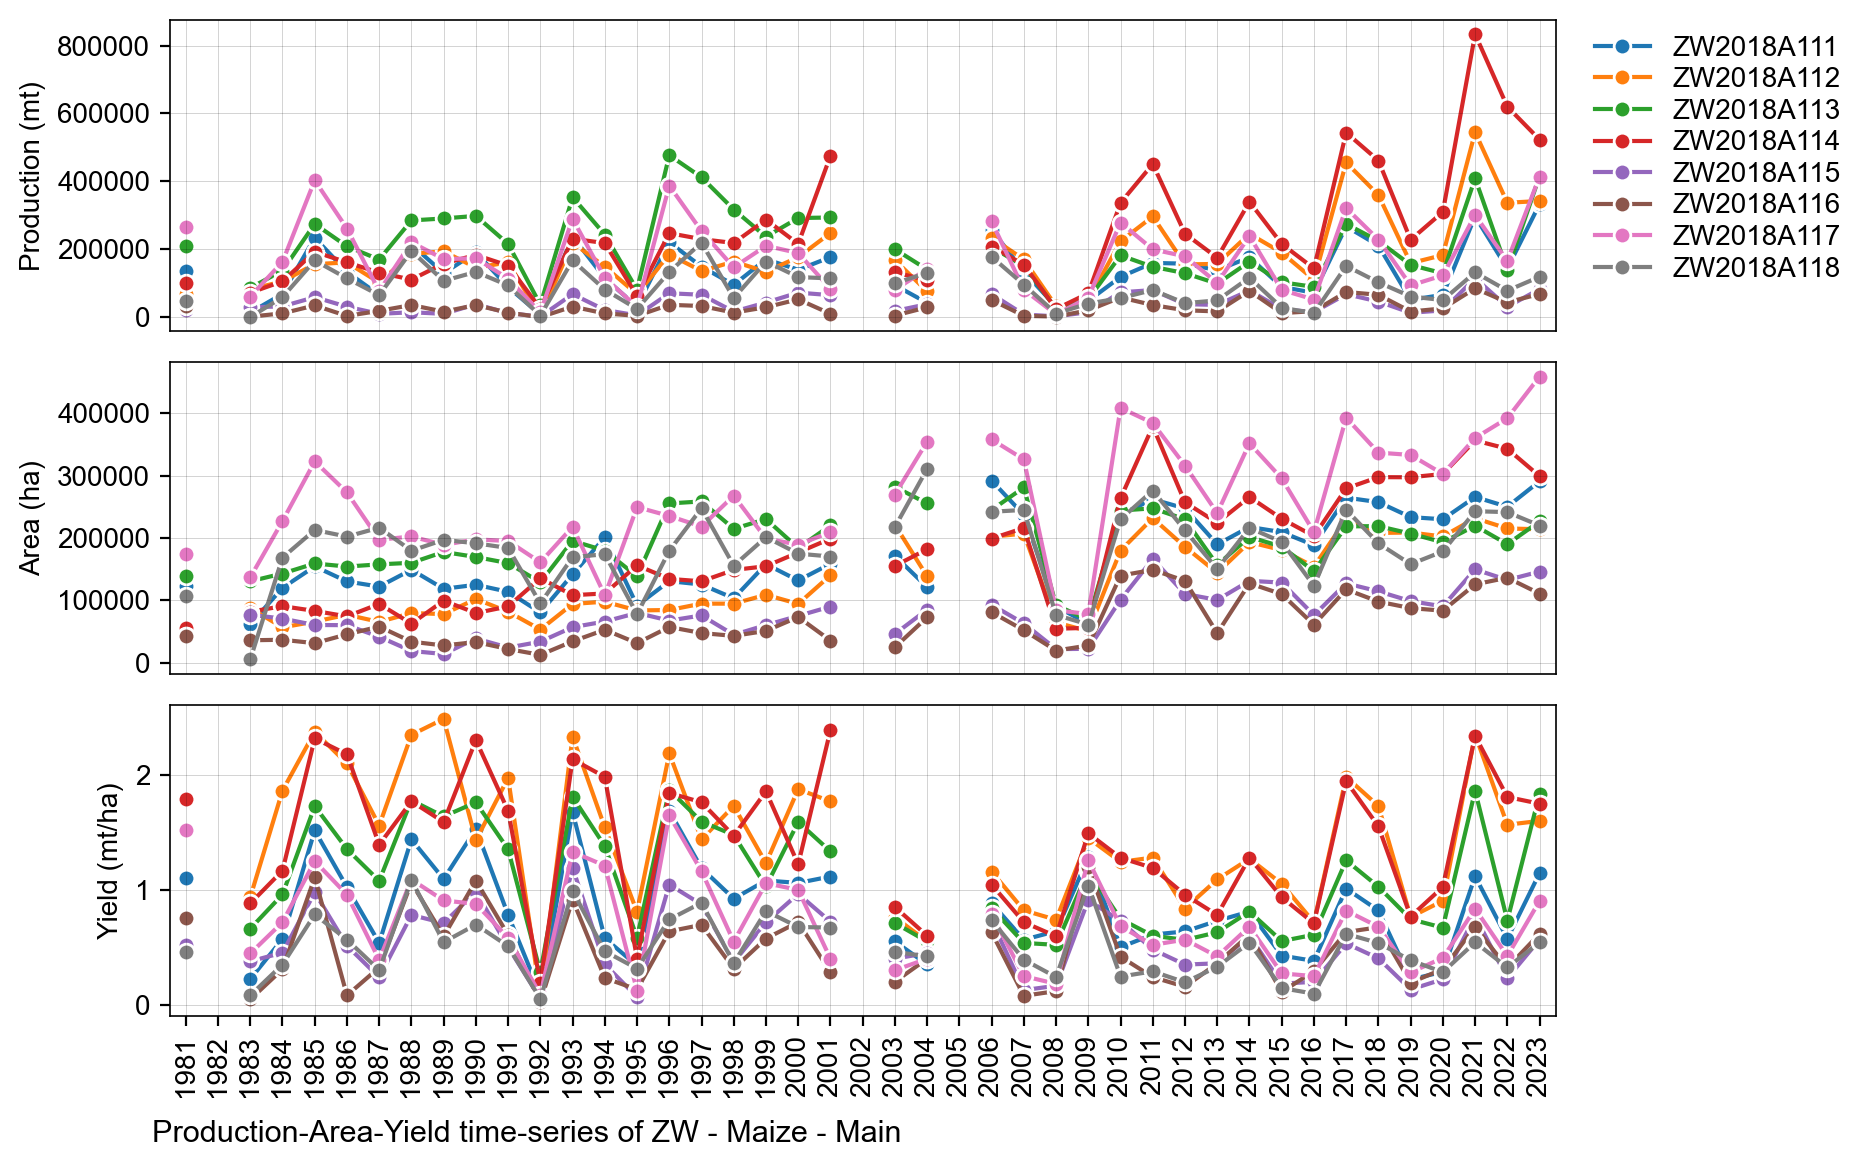

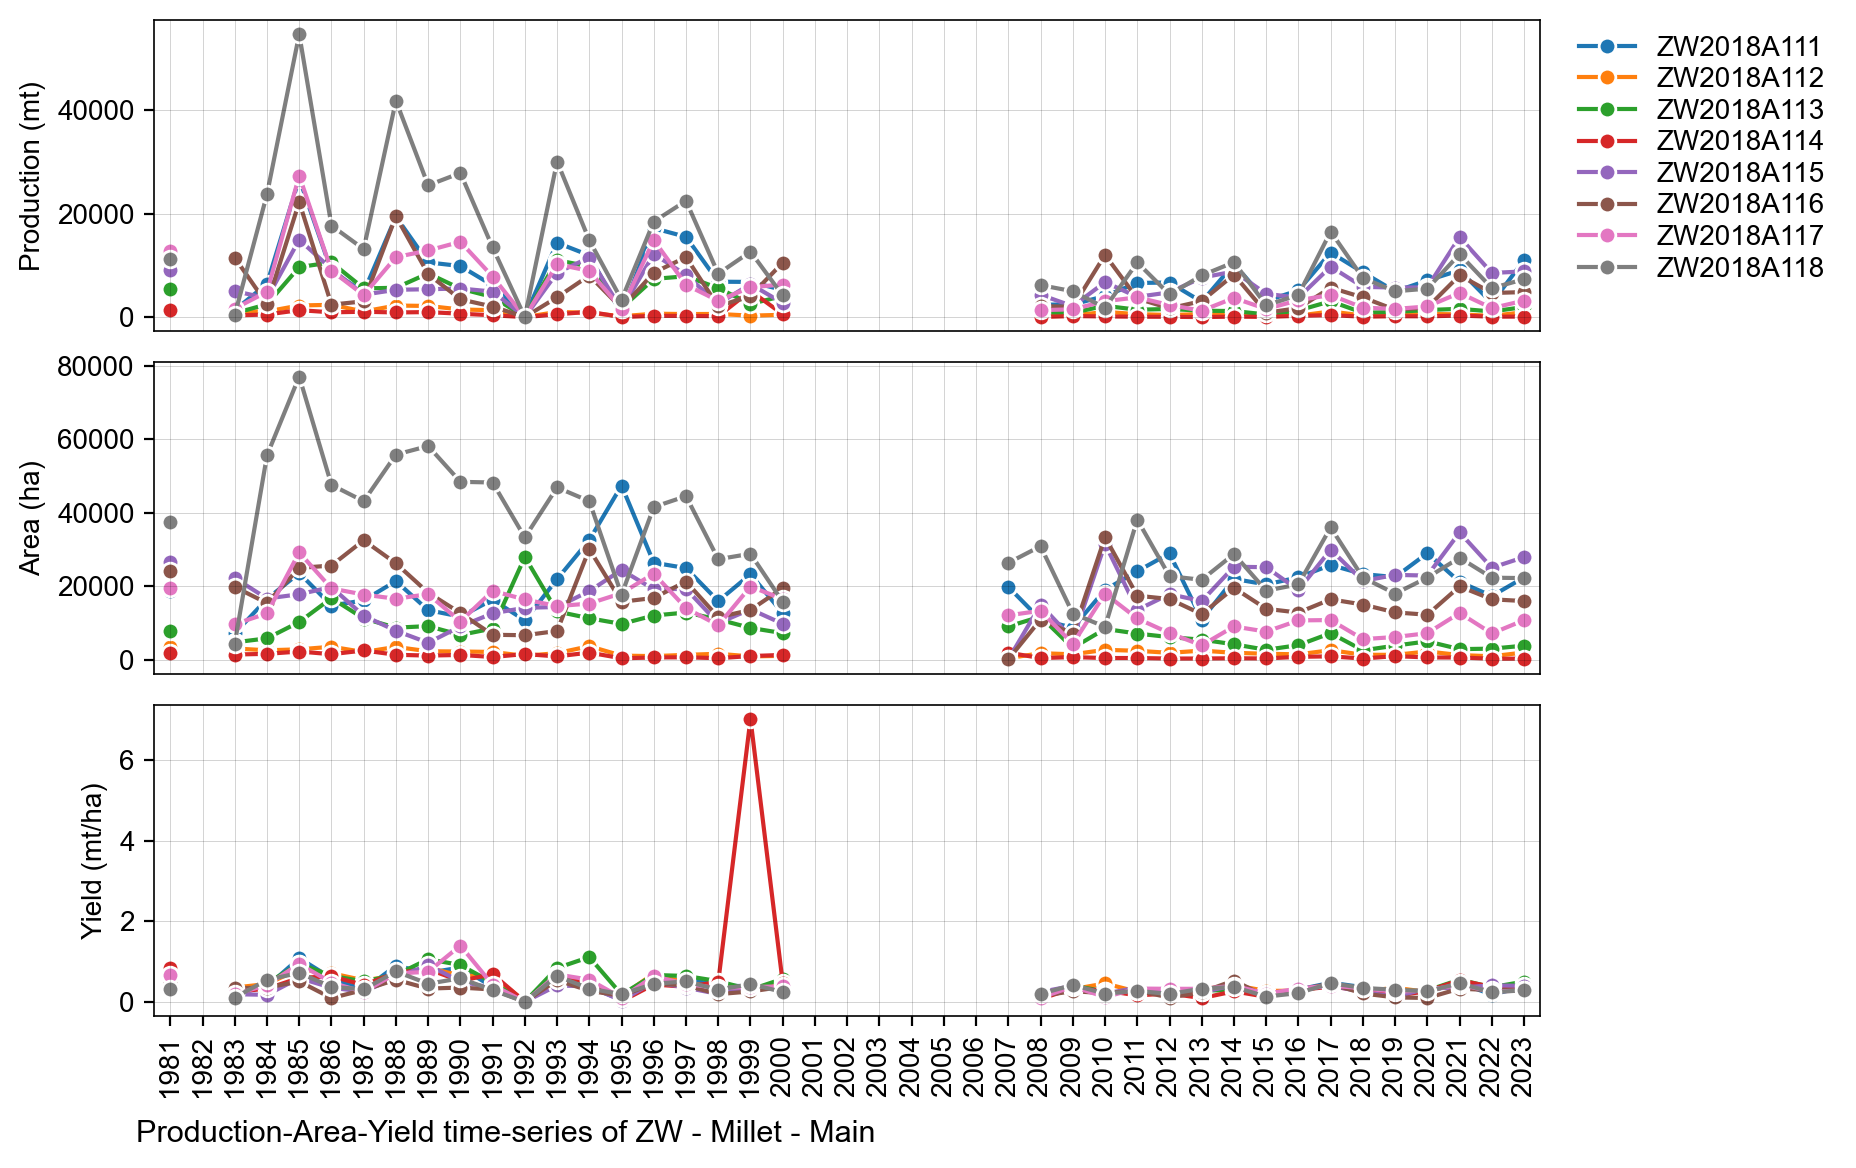

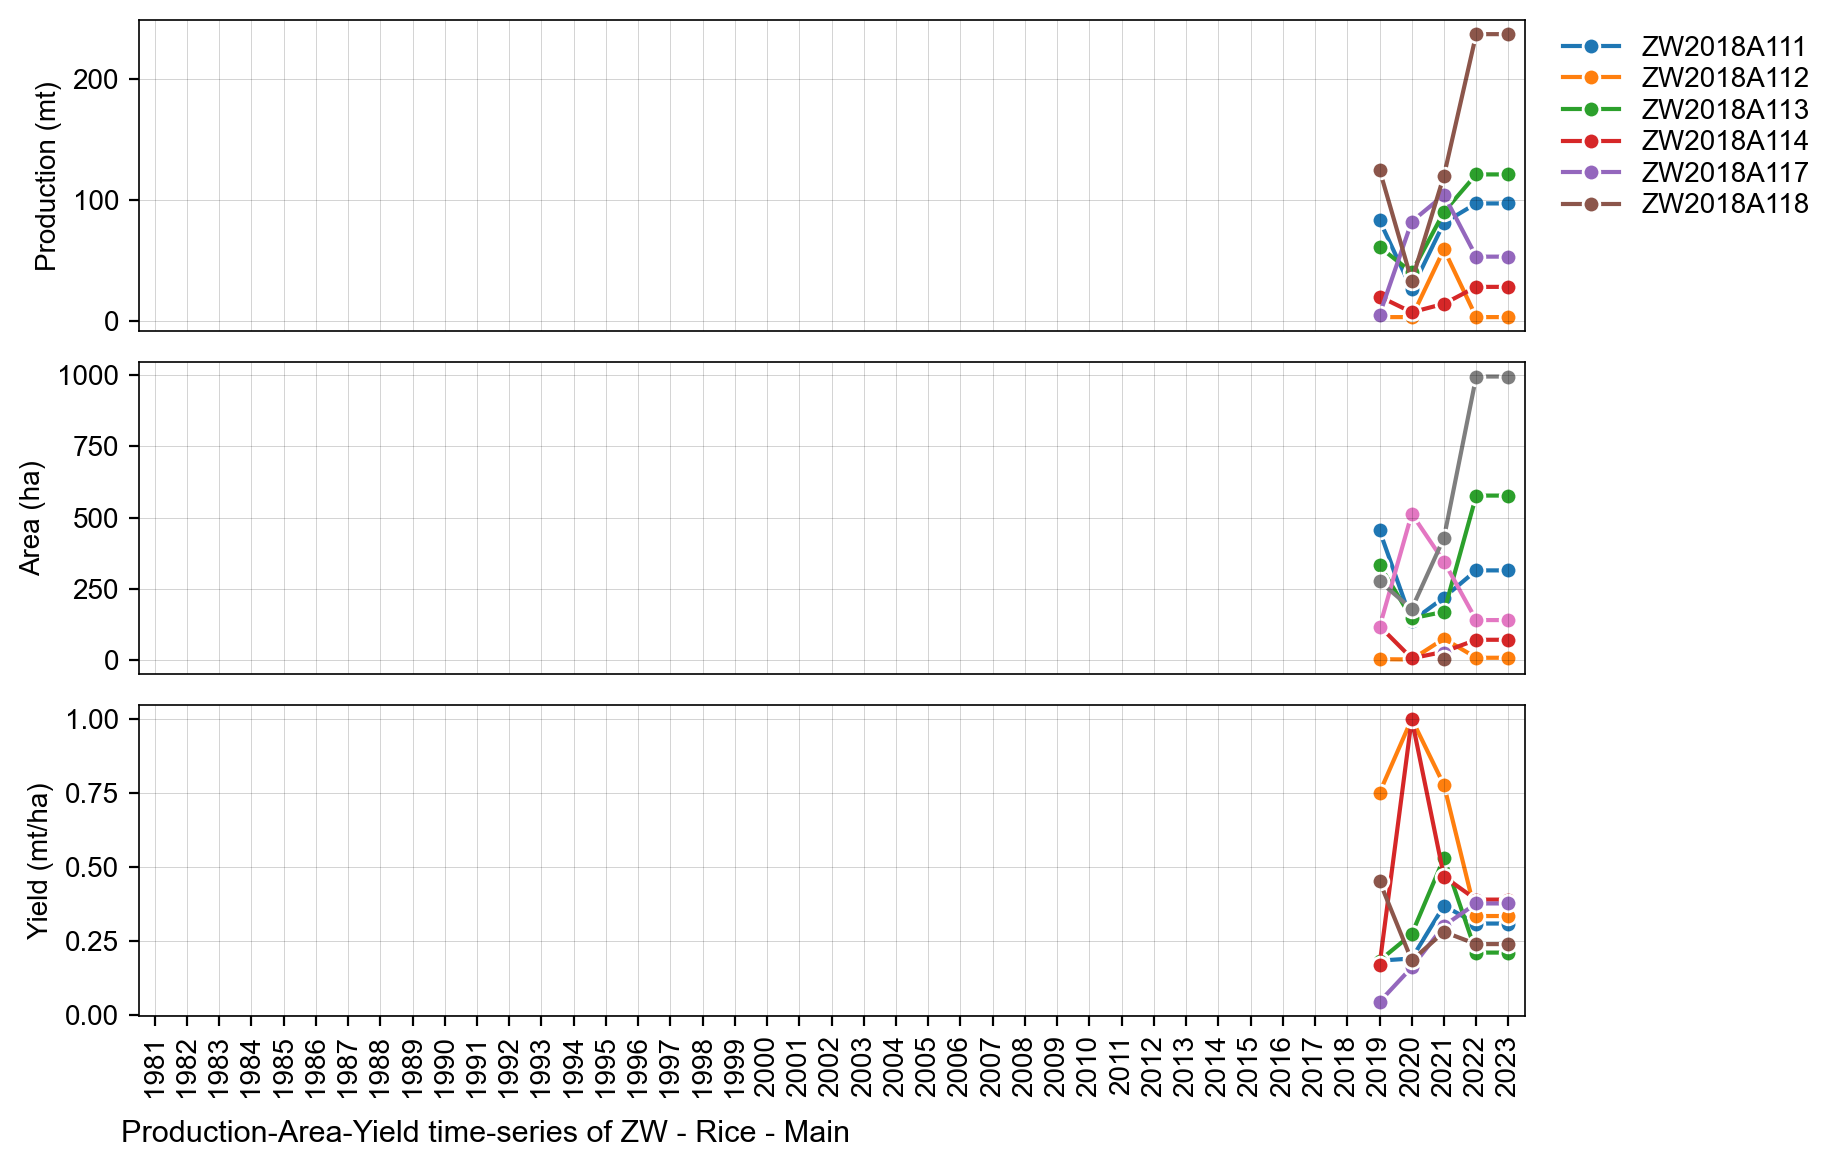

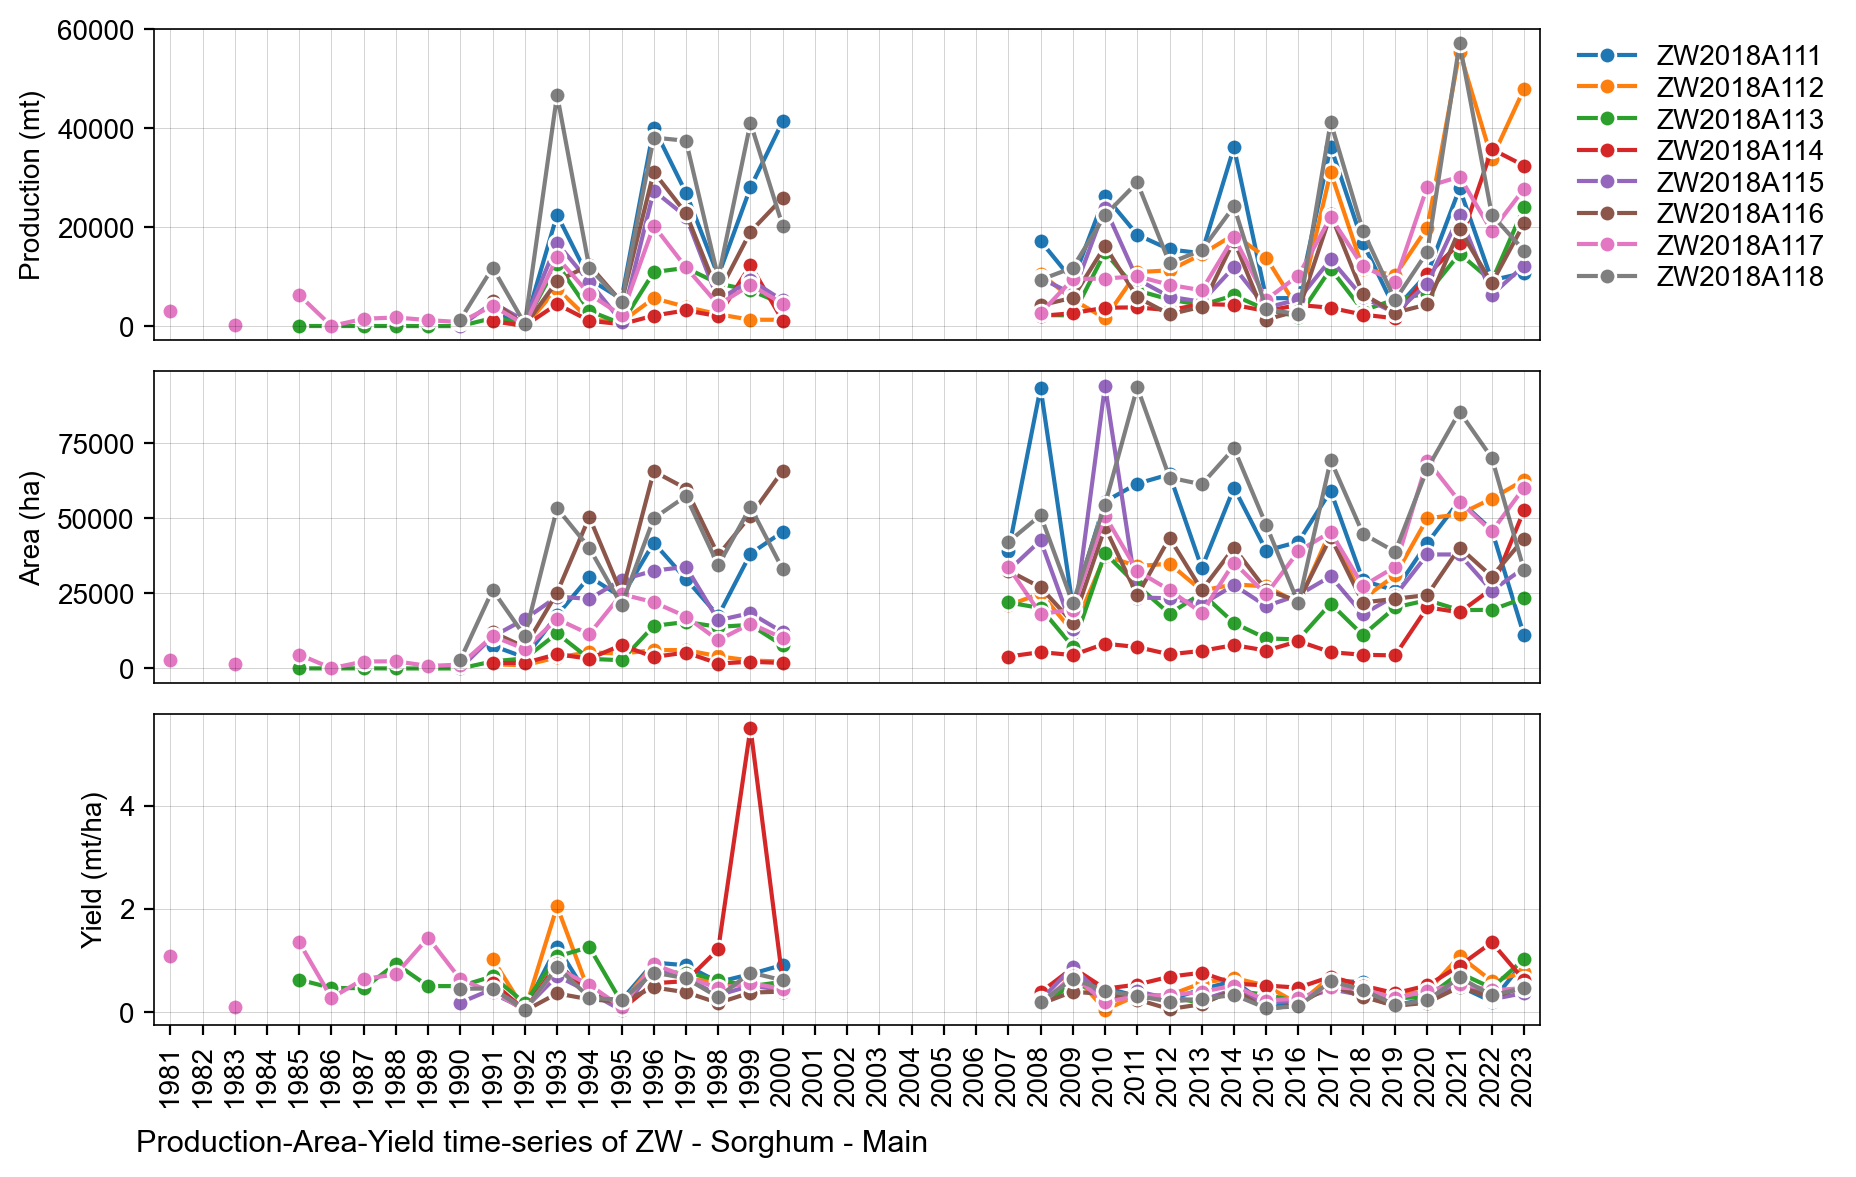

In [13]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'ZW', 'Zimbabwe'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Cassava', 'Main'],
    ['Cowpea', 'Main'],
    ['Groundnuts (In Shell)', 'Main'],

    ['Maize', 'Main'],
    ['Millet', 'Main'],
    ['Rice', 'Main'],
    ['Sorghum', 'Main'],

]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    if len(sub)<5:
        continue
    fig = PlotLinePAY(sub, year, footnote)  # , fn_save)

# ----------------------------------------------- #